# Analysis Project: Patch Duration vs. Morphological Calls(63x) per User

##### Updated CSV Date: 3/22/2018 & Data: 9/01/2017 - 01/10/2017

In [1]:
#Import necessary functions
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Makes a white backround with gray horizontal gridmarks at y-values
sns.set_style("whitegrid")
sns.set_context("notebook")

#Context: paper
#Context: notebook
#Context: talk
#Context: poster

In [2]:
#ps = patch_seq csv file
ps = pd.read_csv("patch_seq_log_mouse.csv")

In [3]:
#list_initial = list with specific columns used from csv file
list_initial = ["Date", "User", "Rig #", "63x go no go", "Time spent extracting cytosol", "Time spent retracting pipette", 
                "patch duration", "PCR cycles", "SM_QC_PF", "Bad dates"]
ps = ps[list_initial]
ps.head()

,Date,User,Rig #,63x go no go,Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates
0,170104,P1,5,qc,2.3,NaN,11.78333333,18.0,pass,x
1,170104,P1,5,qc,2.316666667,NaN,12.21666667,18.0,pass,x
2,170104,P1,5,qc,2.45,NaN,11.78333333,18.0,pass,x
3,170104,P1,5,qc,2.316666667,NaN,12.45,18.0,pass,x
4,170104,P1,5,qc,2.35,NaN,12.36666667,18.0,pass,x


### Categorizing & Filtering the columns

In [4]:
#Changing Date Format
ps["Date"] = pd.to_datetime(ps["Date"], format = "%y%m%d", errors = "coerce")

#Changing String to Numerical
ps["Time spent extracting cytosol"] = pd.to_numeric(ps["Time spent extracting cytosol"].str.replace(' ',''), errors ='coerce')
ps["patch duration"] = pd.to_numeric(ps["patch duration"].str.replace(' ',''), errors ='coerce')
ps["Time spent retracting pipette"] = pd.to_numeric(ps["Time spent retracting pipette"].str.replace(' ',''), errors ='coerce')

#Categories
ps["User"] = ps["User"].astype("category")
ps["Rig #"] = ps["Rig #"].astype("category")
ps["63x go no go"] = ps["63x go no go"].astype("category")
ps["PCR cycles"] = ps["PCR cycles"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps["Bad dates"] = ps["Bad dates"].astype("category")

#Filtering Columns
ps = ps[ps["PCR cycles"] == 21]      #Shows 21 pcr cycles
ps = ps[ps["SM_QC_PF"] != "cnt"]     #Shows everything except (cnt = control)
ps = ps[ps["Bad dates"] != "x"]      #Shows everthing except (x = contaminated)
ps = ps[ps["Time spent extracting cytosol"] <= 10]

#Dropping blank columns
ps = ps.drop("Bad dates", 1)
ps["Time spent retracting pipette"] = ps["Time spent retracting pipette"].fillna(0)
ps.dropna(subset = ["User", "63x go no go", "Time spent extracting cytosol", "Time spent retracting pipette", "patch duration", 
                    "SM_QC_PF"], inplace = True)
ps.head()

,Date,User,Rig #,63x go no go,Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF
1634,2017-04-19,P2,6,qc,1.800000,0.0,4.333333,21.0,fail
1635,2017-04-19,P2,6,qc,1.666667,0.0,6.566667,21.0,pass
1636,2017-04-19,P2,6,qc,1.433333,0.0,8.033333,21.0,fail
1637,2017-04-19,P2,6,qc,2.350000,0.0,7.416667,21.0,pass
1638,2017-04-19,P2,6,qc,2.216667,0.0,4.166667,21.0,pass


### Creating Recording Duration Column

In [5]:
ps["Recording Duration"] = ps["patch duration"] - ps["Time spent extracting cytosol"] - ps["Time spent retracting pipette"]
ps = ps[ps["Recording Duration"] > 0] #Only shows postive values

### Renaming columns

In [6]:
ps.rename(columns = {"63x go no go" : "Morphology",
                     "Time spent extracting cytosol" : "Extraction Duration", 
                     "Time spent retracting pipette" : "Retraction Duration",
                     "patch duration" : "Patch Duration"}, inplace = True)

### Renaming Morphological Calls

In [7]:
ps.Morphology.value_counts()

qc                  945
63x go              321
63x no go           299
passed              220
pending_ephys_qc      3
Name: Morphology, dtype: int64

In [8]:
ps.Morphology.cat.rename_categories({"qc" : "QC", 
                                     "63x go" : "Go",
                                     "63x no go" : "No Go", 
                                     "passed" : "Pass", 
                                     "pending_ephys_qc" : "Pending QC"}, inplace = True)

In [9]:
#Above method doesn't work with pandas 0.19
#Rusty's method below works with pandas 0.19

#dictionary = {"qc" : "QC", 
#              "63x go" : "Go",
#              "63x no go" : "No Go", 
#              "passed" : "Pass", 
#              "pending_ephys_qc" : "Pending QC"}
#
#ps["Morphology"] = ps["Morphology"].map(dictionary)
#ps = ps.drop("Morphology", 1)
#ps

In [10]:
ps.Morphology.value_counts()

QC            945
Go            321
No Go         299
Pass          220
Pending QC      3
Name: Morphology, dtype: int64

### Info

In [11]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 1634 to 4992
Data columns (total 10 columns):
Date                   1788 non-null datetime64[ns]
User                   1788 non-null category
Rig #                  1776 non-null category
Morphology             1788 non-null category
Extraction Duration    1788 non-null float64
Retraction Duration    1788 non-null float64
Patch Duration         1788 non-null float64
PCR cycles             1788 non-null category
SM_QC_PF               1788 non-null category
Recording Duration     1788 non-null float64
dtypes: category(5), datetime64[ns](1), float64(4)
memory usage: 93.8 KB


In [12]:
ps.Morphology.value_counts()

QC            945
Go            321
No Go         299
Pass          220
Pending QC      3
Name: Morphology, dtype: int64

In [13]:
ps.User.value_counts()

P2    531
P1    475
P8    447
P9    117
PB     82
P6     74
PA     62
P5      0
P3      0
P0      0
Name: User, dtype: int64

### Date for this Dataset

In [14]:
ps.tail(600) #look at 3792

,Date,User,Rig #,Morphology,Extraction Duration,Retraction Duration,Patch Duration,PCR cycles,SM_QC_PF,Recording Duration
3767,2017-08-30,P8,6,No Go,0.383333,0.000000,11.783333,21.0,pass,11.400000
3774,2017-08-31,P2,7,Go,0.633333,0.000000,11.800000,21.0,pass,11.166667
3775,2017-08-31,P2,7,Go,1.033333,0.000000,11.866667,21.0,pass,10.833333
3776,2017-08-31,P2,7,Go,1.183333,0.000000,12.616667,21.0,pass,11.433333
3779,2017-08-31,P8,6,Go,0.850000,0.000000,10.416667,21.0,pass,9.566667
3780,2017-08-31,P8,6,No Go,0.566667,0.000000,11.200000,21.0,pass,10.633333
3781,2017-08-31,P8,6,No Go,0.133333,0.000000,10.466667,21.0,pass,10.333333
3782,2017-08-31,P8,6,Go,0.583333,0.000000,11.566667,21.0,pass,10.983333
3783,2017-08-31,P8,6,No Go,0.966667,0.000000,12.116667,21.0,pass,11.150000
3784,2017-08-31,P8,6,Go,0.233333,0.000000,10.300000,21.0,pass,10.066667


In [15]:
#3792 is where 9/01/2017 starts (production date)
ps1 = ps.loc[3792:]
ps1.head()

,Date,User,Rig #,Morphology,Extraction Duration,Retraction Duration,Patch Duration,PCR cycles,SM_QC_PF,Recording Duration
3792,2017-09-01,P2,7,Go,0.850000,0.0,9.966667,21.0,pass,9.116667
3793,2017-09-01,P2,7,Go,1.300000,0.0,10.450000,21.0,pass,9.150000
3795,2017-09-01,P2,7,Go,1.033333,0.0,12.200000,21.0,pass,11.166667
3798,2017-09-01,P8,6,No Go,0.983333,0.0,11.600000,21.0,pass,10.616667
3800,2017-09-01,P8,6,No Go,0.200000,0.0,10.100000,21.0,pass,9.900000


In [16]:
ps1.tail()

,Date,User,Rig #,Morphology,Extraction Duration,Retraction Duration,Patch Duration,PCR cycles,SM_QC_PF,Recording Duration
4949,2018-01-08,PA,7,No Go,2.083333,2.466667,10.150000,21.0,pass,5.600000
4959,2018-01-09,P2,3,No Go,0.466667,1.616667,13.550000,21.0,pass,11.466667
4970,2018-01-09,PA,7,No Go,2.033333,2.183333,11.566667,21.0,pass,7.350000
4975,2018-01-10,P9,6,No Go,0.516667,2.300000,10.700000,21.0,pass,7.883333
4992,2018-01-10,P8,4,No Go,0.616667,2.433333,11.200000,21.0,pass,8.150000


### Boxplot of Patch Duration vs. Morphological Calls

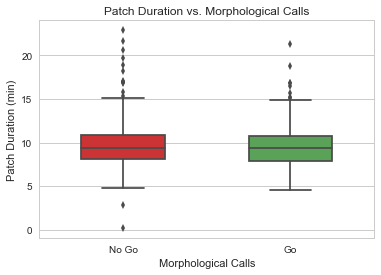

In [62]:
sns.boxplot(x = "Morphology", 
            y = "Patch Duration", 
            data = ps1, 
            order = ["No Go","Go"],
            palette = ['#e41a1c', '#4daf4a'],
            width = 0.5).set_title("Patch Duration vs. Morphological Calls")
plt.xlabel("Morphological Calls")
plt.ylabel("Patch Duration (min)")
plt.savefig("box_patch_duration_vs_morph")

### Boxplot of Patch Duration vs. Morphological Calls per User

Text(0,0.5,u'Patch Duration (min)')

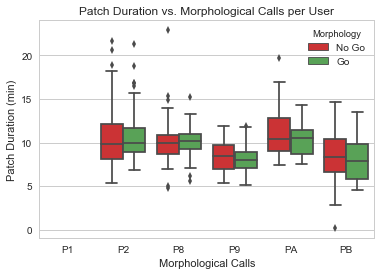

In [60]:
#No viable data for P1

sns.boxplot(x = "User", 
            y = "Patch Duration", 
            hue = "Morphology", 
            data = ps1, 
            order = ["P1", "P2", "P8", "P9", "PA", "PB"], 
            hue_order = ["No Go","Go"],
            palette = ["#e41a1c", "#4daf4a"]).set_title("Patch Duration vs. Morphological Calls per User")
plt.xlabel("Morphological Calls")
plt.ylabel("Patch Duration (min)")
#plt.legend(loc = "upper right")
#plt.savefig("box_patch_duration_vs_morph_user")

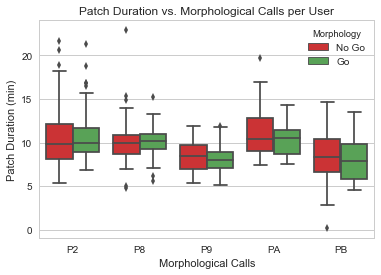

In [41]:
#Excluded P1 from the graph

sns.boxplot(x = "User", 
            y = "Patch Duration", 
            hue = "Morphology", 
            data = ps1, 
            order = ["P2", "P8", "P9", "PA", "PB"], 
            hue_order = ["No Go","Go"],
            palette = ["#e41a1c", "#4daf4a"]).set_title("Patch Duration vs. Morphological Calls per User")
plt.xlabel("Morphological Calls")
plt.ylabel("Patch Duration (min)")
#plt.legend(loc = "upper right")
plt.savefig("box_patch_duration_vs_morph_user")

### Extras Over time plots

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,u'Count of Morphological Calls')

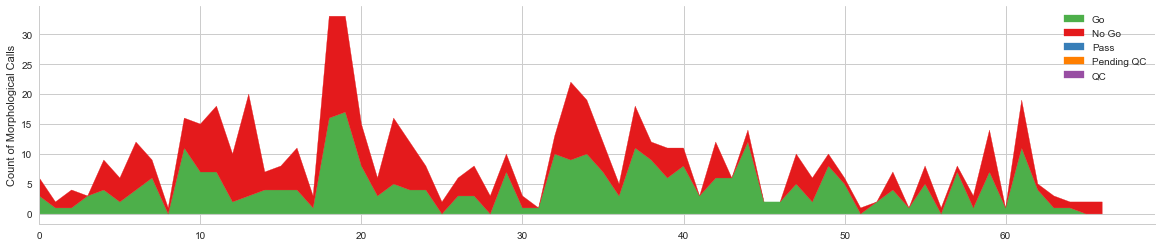

In [58]:
colors = {
    "Go": "#4daf4a",
    "No Go": "#e41a1c",
    "Pass": "#377eb8",
    "Pending QC": "#ff7f00",
    "QC": "#984ea3"
}

plt.figure(figsize = (20,4))
x = np.arange(0,len(ps1["Date"].unique()))
bottom = np.zeros(len(ps1["Date"].unique()))
for i, morph in enumerate(sorted(ps["Morphology"].unique())):
    y = [len(ps1[(ps1["Date"] == date) & (ps["Morphology"] == morph)]) for date in ps1["Date"].unique()]
    y2 = y+bottom
    plt.fill_between(x, bottom, y2,where=y2 > bottom, color = colors[morph], interpolate=True, label = morph)
                #color = colors[morph], label = morph)
    #facecolor=colors[morph]
    bottom += y

plt.legend()
sns.despine()
plt.xlim(0,)
plt.ylabel("Count of Morphological Calls")

### Plot over time for patch duration for each user

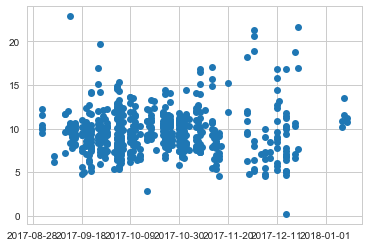

In [43]:
plt.plot_date(ps1["Date"], ps1["Patch Duration"])

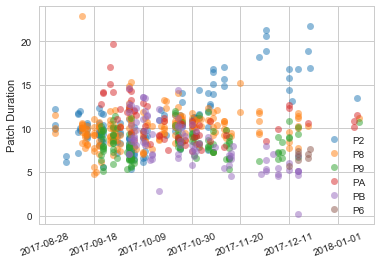

In [44]:
for user in ps1["User"].unique():
    plt.plot_date(ps1[ps1["User"] == user]["Date"], ps1[ps1["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

In [45]:
fil_ps1 = ps1[ps1["User"] == "P1"]
fil_ps2 = ps1[ps1["User"] == "P2"]
fil_ps8 = ps1[ps1["User"] == "P8"]
fil_ps9 = ps1[ps1["User"] == "P9"]
fil_psa = ps1[ps1["User"] == "PA"]
fil_psb = ps1[ps1["User"] == "PB"]

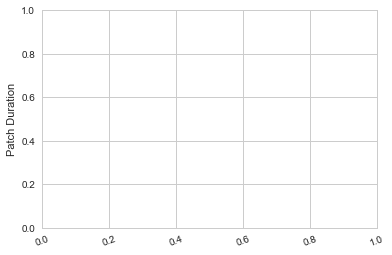

In [46]:
for user in fil_ps1["User"].unique():
    plt.plot_date(fil_ps1[fil_ps1["User"] == user]["Date"], fil_ps1[fil_ps1["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

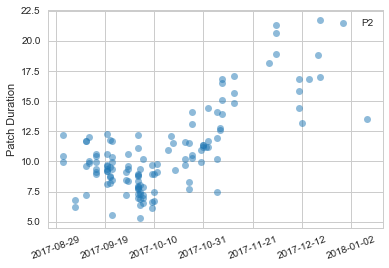

In [47]:
for user in fil_ps2["User"].unique():
    plt.plot_date(fil_ps2[fil_ps2["User"] == user]["Date"], fil_ps2[fil_ps2["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

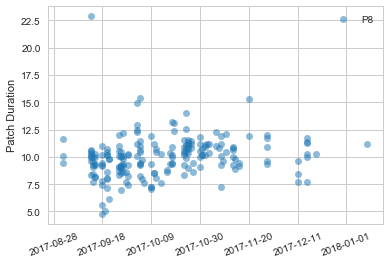

In [48]:
for user in fil_ps8["User"].unique():
    plt.plot_date(fil_ps8[fil_ps8["User"] == user]["Date"], fil_ps8[fil_ps8["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

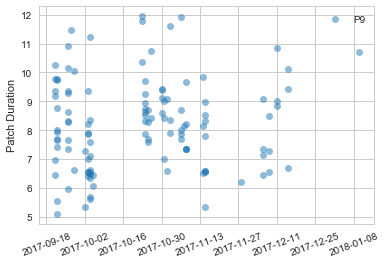

In [49]:
for user in fil_ps9["User"].unique():
    plt.plot_date(fil_ps9[fil_ps9["User"] == user]["Date"], fil_ps9[fil_ps9["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

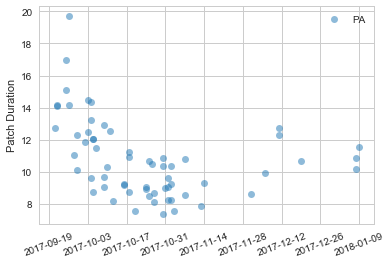

In [50]:
for user in fil_psa["User"].unique():
    plt.plot_date(fil_psa[fil_psa["User"] == user]["Date"], fil_psa[fil_psa["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

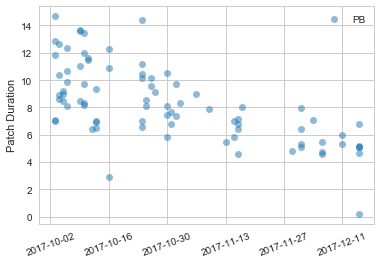

In [51]:
for user in fil_psb["User"].unique():
    plt.plot_date(fil_psb[fil_psb["User"] == user]["Date"], fil_psb[fil_psb["User"] == user]["Patch Duration"],
                  label = user, alpha = .5)
plt.ylabel("Patch Duration")
plt.xticks(rotation = 20)
plt.legend()

### Extra Info: Countplot of Patch Duration vs. Morphological Calls per User

In [52]:
#Lisa has better stacked plot of Morph vs User

Text(0,0.5,u'Count of Morphological Calls')

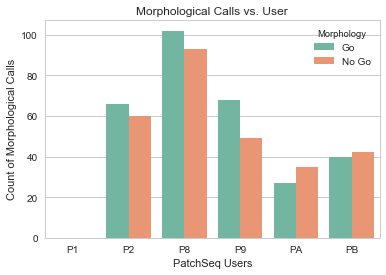

In [59]:
sns.countplot(x = "User", 
              hue = "Morphology", 
              data = ps1, 
              order = ["P1", "P2", "P8", "P9", "PA", "PB"], 
              hue_order = ["Go","No Go"], 
              palette = "Set2").set_title("Morphological Calls vs. User")
plt.xlabel("PatchSeq Users")
plt.ylabel("Count of Morphological Calls")

### Trying Aaron's stacked plot

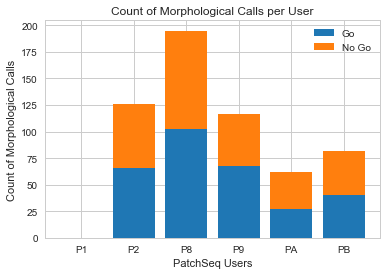

In [55]:
x = ["P1", "P2", "P8", "P9", "PA", "PB"]
morph = ["Go", "No Go"]
#color = ["r", "g"]

bottom = np.zeros(len(x))
y = np.zeros(len(x))
for mp in morph:
    bottom = bottom + y
    y = [len(ps1[(ps1["User"] == f) & (ps1["Morphology"] == mp)]) for f in x]
    plt.bar(x, y, bottom = bottom, label = mp)
    
plt.xlabel("PatchSeq Users")
plt.ylabel("Count of Morphological Calls")
plt.legend()
plt.title("Count of Morphological Calls per User")
plt.savefig("count_patch_duration_vs_morph")